In [17]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics, preprocessing
from classes.superclasse.ModeloBase import ModeloBase

from skopt.space import Real, Integer, Categorical
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1.Baixar Dados

A função `baixar_dados` baixa os dados históricos de uma ação do Yahoo Finance, permitindo ajustar o período e o intervalo dos dados.

In [2]:
# Função para baixar dados do Yahoo Finance
def baixar_dados(symbol, periodo="5y", intervalo="1d"):
    data = yf.download(symbol, period=periodo, interval=intervalo)
    return data["Close"].values

## 2. Criar Janelas Temporais e Normalizar Dados
A função `criar_janela_temporal` cria as janelas de entrada e saída para o modelo de previsão. As entradas são geradas com base no número de `lags` definido e as saídas são os valores de fechamento seguintes. A função `Normalizar` transforma os dados para o intervalo de 0 e 1.

In [3]:
# Função para criar padrões de entrada e saída
def criar_janela_temporal(y, lags):
    X, Y = [], []
    for i in range(len(y) - lags):
        X.append(y[i:i+lags])
        Y.append(y[i+lags])
    return np.array(X).reshape(-1, lags), np.array(Y)

In [4]:
def normalizar_serie(serie_temporal: np.ndarray) -> np.ndarray:
    # Criando o scaler
    scaler = preprocessing.StandardScaler()

    # Aprendendo a escala com os dados
    for x in serie_temporal:
        scaler.learn_one({"valor": x[0]})  # Não sobrescrevemos o scaler

    # Transformando a série
    serie_normalizada = np.array([scaler.transform_one({"valor": x[0]})["valor"] for x in serie_temporal])

    # Garantindo que o shape permaneça (1244, 1)
    return serie_normalizada.reshape(-1, 1)

# 3.Inicializar Modelos

In [5]:
def inicializar_modelos(modelo_classe, detector_classe, **kwargs):

     # Instancia o modelo com os parâmetros fornecidos
     modelo_instancia = modelo_classe(**kwargs)

     # Instancia o detector com os parâmetros fornecidos
     detector_instancia = detector_classe(**kwargs)

     return modelo_instancia, detector_instancia

## 4. Treinamento do Modelo de Machine Learning
A função `treinamento_modelo` realiza o treinamento inicial do modelo com os primeiros dados disponíveis, usando o tamanho do batch especificado.

In [6]:
def treinamento_modelo_batch(modelo, X, y):
    # Treinamento do modelo usando o método 'treinar' da subclasse
    modelo.treinar(X, y)

    # Cálculo do erro médio (adapte para modelos online, se necessário)

    if isinstance(modelo, ModeloBase):  # Verifica se é uma instância da superclasse dos modelos offline
      erro_medio = np.abs(np.mean(y - modelo.prever(X))) # Calcula erro para modelos offline

    else: # Senão calcula para modelos online
      predicoes = []
      for i in range(len(X)):
          predicoes.append(modelo.prever(X[i].reshape(1, -1))[0]) # Faz as predições para cada exemplo em X
      erro_medio = np.abs(np.mean(y.ravel() - np.array(predicoes))) # Calcula o erro médio

    return erro_medio

In [7]:
def treinamento_online_many(modelo, X, y, tamanho_batch):  # Adiciona 'tamanho_batch' como parâmetro
    # Treina o modelo com os primeiros 'tamanho_batch' exemplos
    modelo.treinar(X[:tamanho_batch], y[:tamanho_batch])
    return modelo

In [8]:
def prequential_batch(X, Y, tamanho_batch, modelo_classe, detector_classe, **kwargs):
    """
    Realiza a previsão de valores continuamente, detectando mudanças nos dados (drift)
    e retreinando o modelo quando necessário.

    Args:
        X: Dados de entrada.
        Y: Dados de saída.
        tamanho_batch: Tamanho do batch para treinamento inicial e retreinamento.
        modelo_classe: Classe do modelo a ser usado (subclasse de ModeloBase).
        detector_classe: Classe do detector de drift a ser usado (subclasse de DetectorDriftBase).
        **kwargs: Parâmetros adicionais para o modelo e detector.

    Returns:
        predicoes: Lista de previsões.
        deteccoes: Lista de índices onde o drift foi detectado.
    """
    predicoes, erros, deteccoes = [], [], []
    mae = metrics.MAE()

    # Inicializando o modelo e o detector usando as classes
    modelo, detector = inicializar_modelos(modelo_classe, detector_classe, **kwargs)

    # Treina o modelo e atualiza o detector
    erro_inicial = treinamento_modelo_batch(modelo, X[:tamanho_batch], Y[:tamanho_batch])
    detector.atualizar(erro_inicial)  # Usa o método 'atualizar' da subclasse

    drift_ativo = False

    for i in range(tamanho_batch, len(X)):
        # Realiza a predição usando o método 'prever' da subclasse
        entrada = X[i].reshape(1, -1)
        y_pred = modelo.prever(entrada)[0]
        erro = abs(Y[i][0] - y_pred)

        predicoes.append(y_pred)
        erros.append(erro)
        mae.update(Y[i][0], y_pred)

        # Atualiza o detector usando o método 'atualizar' da subclasse
        detector.atualizar(erro)

        # Se drift for detectado pela primeira vez
        if detector.drift_detectado and not drift_ativo:  # Usa a propriedade 'drift_detectado'
            deteccoes.append(i)
            print(f"\nMudança detectada no índice {i}, começando a coletar dados para retreino...")
            drift_ativo = True
            janela_X, janela_y = [], []

        # Se drift já foi detectado, inicia-se a coleta dos dados
        if drift_ativo:
            janela_X.append(X[i])
            janela_y.append(Y[i])

            if len(janela_X) >= tamanho_batch:
                print(f"Janela completa com {len(janela_X)} amostras. Retreinado com dados do índice {i - tamanho_batch} até {i}.")
                drift_ativo = False

                # Inicializando o modelo e o detector com novas instâncias
                modelo, detector = inicializar_modelos(modelo_classe, detector_classe, **kwargs)

                # Treina o modelo e atualiza o detector
                erro_inicial = treinamento_modelo_batch(modelo, np.array(janela_X), np.array(janela_y))
                detector.atualizar(erro_inicial)  # Usa o método 'atualizar' da subclasse

    # Calculando o desvio padrão dos erros com NumPy
    desvio_padrao = np.std(erros)

    print("Modelo utilizado:", modelo)
    print("Detector utilizado:", detector)
    print(f"MAE Modelo Batch: {mae.get()}")
    print(f"Desvio Padrão dos Erros: {desvio_padrao}")
    
    return predicoes, deteccoes

In [9]:
def prequential_passivo(X, Y, tamanho_batch, modelo_classe, **kwargs):
    """
    Realiza a previsão de valores continuamente para algoritmos online,
    sem detecção de drift e retreinamento.

    Args:
        X: Dados de entrada.
        Y: Dados de saída.
        tamanho_batch: Tamanho do batch para treinamento inicial.
        modelo_classe: Classe do modelo a ser usado (subclasse de ModeloBase).
        **kwargs: Parâmetros adicionais para o modelo.

    Returns:
        predicoes: Lista de previsões.
    """
    predicoes = []
    mae = metrics.MAE()

    # Inicializa o modelo usando a classe e kwargs
    modelo = modelo_classe(**kwargs)

    # Treina o modelo com os primeiros exemplos usando treinamento_online_many
    modelo = treinamento_online_many(modelo, X, Y, tamanho_batch)

    for i in range(tamanho_batch, len(X)):
        # Converte a entrada para o formato que o modelo online espera
        entrada_dict = {f"t{j+1}": value for j, value in enumerate(X[i])}

        # Realiza a predição usando o método 'prever' da subclasse
        y_pred = modelo.prever([X[i]])  # Passa a entrada como uma lista de uma única amostra

        predicoes.append(y_pred)
        mae.update(Y[i][0], y_pred)

        # Atualiza o modelo online usando o método 'treinar' da subclasse
        modelo.treinar([X[i]], [Y[i]])

    print("Modelo utilizado:", modelo)
    print(f"MAE Modelo Online: {mae.get()}")
    return predicoes

In [10]:
def definir_espacos_parametros():
    """
    Define os espaços de parâmetros para cada modelo
    
    Retorna:
    --------
    espacos : dict
        Dicionário com espaços de parâmetros para cada modelo
    """
    espacos = {
        # Modelos offline (scikit-learn)
        "LinearRegressionModelo": {
            "fit_intercept": Categorical([True, False]),
            "normalize": Categorical([True, False])
        },
        "KNeighborsRegressorModelo": {
            "n_neighbors": Integer(1, 20),
            "weights": Categorical(['uniform', 'distance']),
            "p": Integer(1, 2)
        },
        "LassoRegressionModelo": {
            "alpha": Real(0.001, 10.0, prior='log-uniform'),
            "max_iter": Integer(100, 2000),
            "tol": Real(1e-6, 1e-2, prior='log-uniform')
        },
        "MLPRegressorModelo": {
            "hidden_layer_sizes": Categorical([(50,), (100,), (50, 50), (100, 50)]),
            "activation": Categorical(['relu', 'tanh']),
            "solver": Categorical(['adam', 'sgd']),
            "alpha": Real(1e-5, 1e-2, prior='log-uniform'),
            "learning_rate_init": Real(1e-4, 1e-1, prior='log-uniform')
        },
        "RandomForestModelo": {
            "n_estimators": Integer(50, 200),
            "max_depth": Integer(5, 30),
            "min_samples_split": Integer(2, 10),
            "min_samples_leaf": Integer(1, 4)
        },
        "RidgeRegressionModelo": {
            "alpha": Real(0.01, 10.0, prior='log-uniform'),
            "solver": Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'])
        },
        "SVRModelo": {
            "C": Real(0.1, 100, prior='log-uniform'),
            "epsilon": Real(0.01, 1.0, prior='log-uniform'),
            "kernel": Categorical(['linear', 'rbf', 'poly']),
            "gamma": Real(1e-3, 1, prior='log-uniform')
        },
        
        # Modelos online (River)
        "HoeffdingTreeModelo": {
            "grace_period": Integer(50, 200),
            "split_confidence": Real(1e-10, 1e-1, prior='log-uniform'),
            "leaf_prediction": Categorical(['mean', 'model'])
        },
        "SGDModelo": {
            "loss": Categorical(['squared_error', 'absolute_error']),
            "learning_rate": Real(0.001, 0.1, prior='log-uniform'),
            "l2": Real(0.0, 0.1)
        },
        "LinearRegressionRiverModelo": {
            "optimizer_lr": Real(0.001, 0.1, prior='log-uniform'),
            "l2": Real(0.0, 0.1)
        },
        "PARegressorModelo": {
            "C": Real(0.01, 10.0, prior='log-uniform'),
            "mode": Integer(0, 2)
        }
    }
    
    return espacos

In [ ]:
# Função principal para otimizar todos os modelos
# TODO: Verificar se realmente funciona, caso não, apague.
def otimizar_todos_modelos(X, Y, tamanho_batch, lags, modelos_offline=None, modelos_online=None):
    """
    Otimiza todos os modelos especificados e retorna os modelos otimizados
    
    Parâmetros:
    -----------
    X : array-like
        Dados de entrada
    Y : array-like
        Dados alvo
    tamanho_batch : int
        Tamanho do batch para avaliação prequential
    lags : int
        Número de lags na série temporal
    modelos_offline : list, opcional
        Lista de classes de modelos offline para otimizar
    modelos_online : list, opcional
        Lista de classes de modelos online para otimizar
        
    Retorna:
    --------
    modelos_otimizados : dict
        Dicionário com modelos otimizados
    parametros_otimizados : dict
        Dicionário com parâmetros otimizados para cada modelo
    """
    optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)
    espacos = definir_espacos_parametros()
    
    modelos_otimizados = {}
    parametros_otimizados = {}
    
    # Otimizar modelos offline (scikit-learn)
    if modelos_offline:
        for modelo_classe in modelos_offline:
            nome_modelo = modelo_classe.__name__
            if nome_modelo in espacos:
                print(f"\nOtimizando {nome_modelo}...")
                modelo_otimizado, params = optimizer.otimizar_offline(
                    modelo_classe, 
                    espacos[nome_modelo], 
                    X, Y
                )
                modelos_otimizados[nome_modelo] = modelo_otimizado
                parametros_otimizados[nome_modelo] = params
            else:
                print(f"Espaço de parâmetros não definido para {nome_modelo}")
    
    # Otimizar modelos online (River)
    if modelos_online:
        for modelo_classe in modelos_online:
            nome_modelo = modelo_classe.__name__
            if nome_modelo in espacos:
                print(f"\nOtimizando {nome_modelo}...")
                modelo_otimizado, params = optimizer.otimizar_online(
                    modelo_classe, 
                    espacos[nome_modelo], 
                    X, Y, 
                    tamanho_batch
                )
                modelos_otimizados[nome_modelo] = modelo_otimizado
                parametros_otimizados[nome_modelo] = params
            else:
                print(f"Espaço de parâmetros não definido para {nome_modelo}")
    
    return modelos_otimizados, parametros_otimizados

# Plot

In [12]:
def plotar_resultados(Y, lista_predicoes, labels_algoritmos, deteccoes, tamanho_batch):
    plt.figure(figsize=(15, 8))
    indices = range(tamanho_batch, tamanho_batch + len(Y[tamanho_batch:]))

    # Plotar valores verdadeiros
    plt.plot(indices, Y[tamanho_batch:tamanho_batch + len(indices)],
             label="Verdadeiro", linewidth=1.2)

    # Plotar cada conjunto de previsões
    for i, predicoes in enumerate(lista_predicoes):
        Y_plot = Y[tamanho_batch:tamanho_batch + len(predicoes)]
        predicoes = predicoes[:len(Y_plot)]  # Garantir mesmo tamanho
        label = labels_algoritmos[i] if i < len(labels_algoritmos) else f"Previsões {i+1}"
        plt.plot(indices[:len(predicoes)], predicoes, label=label, linewidth=1.2)

    # Aumentar o tamanho dos pontos de detecção
    if deteccoes:
        plt.scatter(deteccoes, [Y[i] for i in deteccoes], color='red',
                   label="Drift Detectado", zorder=3, s=80)

        # Destacar áreas pós-retreino com fundo colorido
        for idx, d in enumerate(deteccoes):
            next_end = min(d + tamanho_batch, indices[-1])
            plt.axvspan(d, next_end, alpha=0.1, color='green', label='_nolegend_')

        print("\nDrift detectado nos índices:", deteccoes)
    else:
        print("\nNenhum drift detectado.")

    plt.legend(fontsize=12)
    plt.title("Predições e Detecção de Drift com Retreino", fontsize=14)
    plt.grid(True, alpha=0.4)

    # Adicionar anotações para mostrar diferenças
    for i in range(len(deteccoes)):
        d = deteccoes[i]
        if d + 5 < len(indices):
            plt.annotate(f"Retreino",
                         xy=(d, Y[d]),
                         xytext=(d+10, Y[d]+0.1),
                         arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                         fontsize=10)

    plt.show()

# Execução dos experimentos

In [13]:
series = [
    "AAPL",
    "B3SA3.SA"
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [14]:
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector 
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector 
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
#from classes.detectores.KSWINDetector import KSWINDetector

from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo 
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo 
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo 
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<class 'classes.modelosOffline.LinearRegressionModelo.LinearRegressionModelo'>
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.DDMDetector.DDMDetector object at 0x301afcce0>
MAE Modelo Batch: [0.09405101]
Desvio Padrão dos Erros: 0.07543383089558894
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x157eebf20>
MAE Modelo Batch: [0.09405101]
Desvio Padrão dos Erros: 0.07543383089558894
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.PageHinkleyDetector.PageHinkleyDetector object at 0x1533a2660>
MAE Modelo Batch: [0.09405101]
Desvio Padrão dos Erros: 0.07543383089558894
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.EDDMDetector.EDDMDetector object at 0x17fc487a0>
MAE Modelo Batch: [0.09405101]
Desvio Padrão dos Erros: 0.07543383089558894
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.det

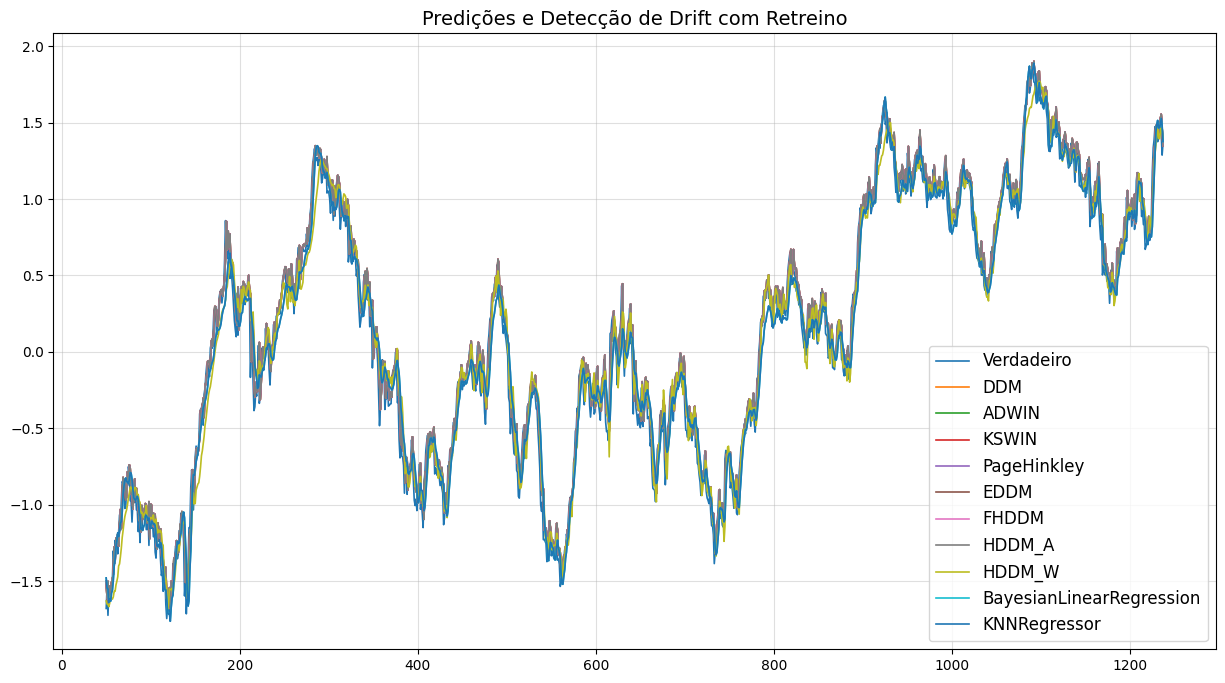

In [15]:
tamanho_batch, lags = 50, 5

# Baixando os dados da ação
serie_temporal = baixar_dados(series[-2])

# normalizando a série temporal
serie_temporal = normalizar_serie(serie_temporal)

# Gerando janelas temporais
X, Y = criar_janela_temporal(serie_temporal, lags)

print(LinearRegressionModelo)

# Prequential com detecção de drift (usando classes)
predicoes_ativa1, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=DDMDetector)
predicoes_ativa2, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=ADWINDetector)
predicoes_ativa4, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=PageHinkleyDetector)
predicoes_ativa5, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=EDDMDetector)
predicoes_ativa6, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=FHDDMDetector)
predicoes_ativa7, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=HDDM_ADetector)
predicoes_ativa8, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=HDDM_WDetector)

# Prequential passivo (usando classes)
#predicoes_passiva1 = prequential_passivo(X, Y, tamanho_batch, modelo_classe=BayesianLinearRegressionModelo)
predicoes_passiva2 = prequential_passivo(X, Y, tamanho_batch, modelo_classe=KNNRegressorOnlineModelo)
predicoes_passiva3 = prequential_passivo(X, Y, tamanho_batch, modelo_classe=LinearRegressionOnlineModelo)
predicoes_passiva4 = prequential_passivo(X, Y, tamanho_batch, modelo_classe=HoeffdingTreeRegressorModelo)

# Plotando os resultados
plotar_resultados(Y, [
                      predicoes_ativa1,
                      predicoes_ativa2,
                      #predicoes_ativa3,
                      predicoes_ativa4,
                      predicoes_ativa5,
                      predicoes_ativa6,
                      predicoes_ativa7,
                      predicoes_ativa8,
                      #predicoes_passiva1,
                      predicoes_passiva2,
                      predicoes_passiva3,
                      predicoes_passiva4,
                      #predicoes_passiva5
                      ],
                  [
                    "DDM",
                    "ADWIN",
                    "KSWIN",
                    "PageHinkley",
                    "EDDM",
                    "FHDDM",
                    "HDDM_A",
                    "HDDM_W",
                    "BayesianLinearRegression",
                    "KNNRegressor",
                    "LinearRegression",
                    "HoeffdingTreeRegressor",
                    #"MLPRegressor"
                   ],
                  deteccoes, tamanho_batch)

[*********************100%***********************]  1 of 1 completed


<class 'classes.modelosOffline.LinearRegressionModelo.LinearRegressionModelo'>
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x302a1c080>
MAE Modelo Batch: [0.09405101]
Desvio Padrão dos Erros: 0.07543383089558894

Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo utilizado: <classes.modelosOffline.KneighborsRegressorModelo.KNeighborsRegressorModelo o

/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

Janela completa com 50 amostras. Retreinado com dados do índice 303 até 353.

Mudança detectada no índice 512, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 511 até 561.

Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.
Modelo utilizado: <classes.modelosOffline.MLPRegressorModelo.MLPRegressorModelo object at 0x30257ef30>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x3023d0bf0>
MAE Modelo Batch: 0.475629278050189
Desvio Padrão dos Erros: 0.4028315189608317

Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.


/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 512, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 511 até 561.


/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 848, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 847 até 897.


/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x301b9eb70>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x301eda030>
MAE Modelo Batch: 0.469218248531855
Desvio Padrão dos Erros: 0.5033003885978301
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x12180aa80>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x301df7d70>
MAE Modelo Batch: 0.10104899241298008
Desvio Padrão dos Erros: 0.07742296008033978

Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do í

/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gabrielfers/Downloads/Concept drift atualizado/concept-drift/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gabrielfers/Downloads/Concept dri

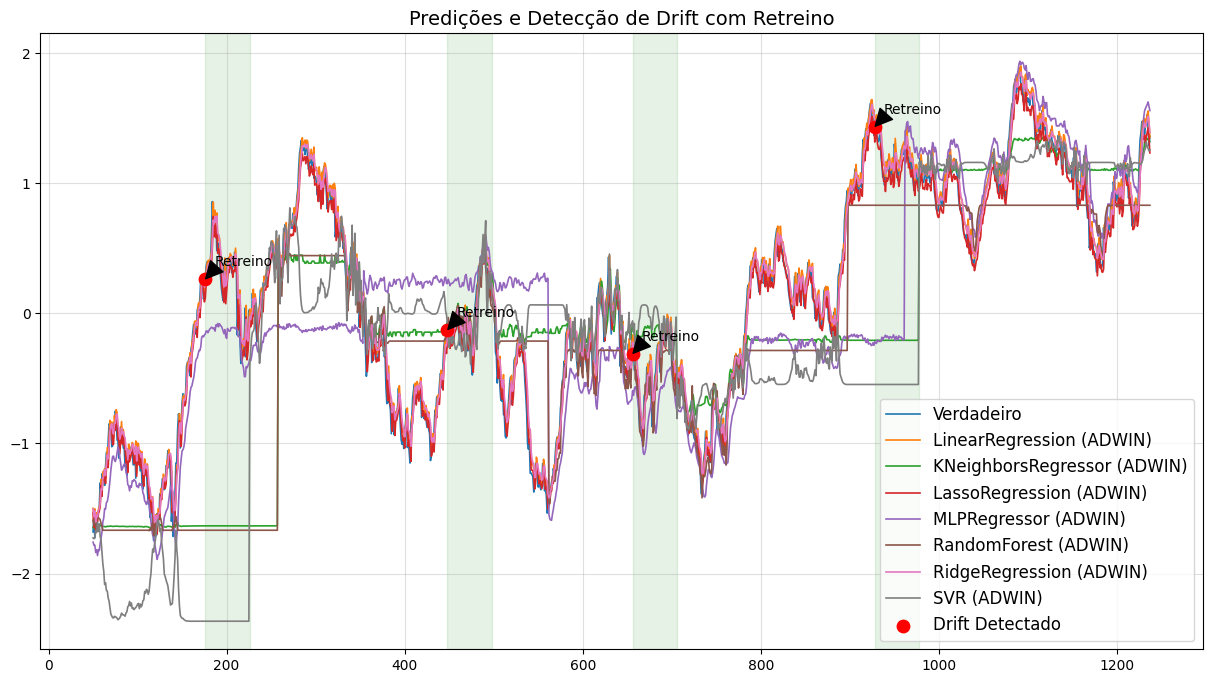

In [16]:
tamanho_batch, lags = 50, 5

# Baixando os dados da ação
serie_temporal = baixar_dados(series[-2])

# normalizando a série temporal
serie_temporal = normalizar_serie(serie_temporal)

# Gerando janelas temporais
X, Y = criar_janela_temporal(serie_temporal, lags)

print(LinearRegressionModelo)

# Prequential com detecção de drift (usando classes)
predicoes_ativa1, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=ADWINDetector)
predicoes_ativa2, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=KNeighborsRegressorModelo, detector_classe=ADWINDetector)
predicoes_ativa3, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LassoRegressionModelo, detector_classe=ADWINDetector)
predicoes_ativa4, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=MLPRegressorModelo, detector_classe=ADWINDetector)
predicoes_ativa5, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=RandomForestModelo, detector_classe=ADWINDetector)
predicoes_ativa6, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=RidgeRegressionModelo, detector_classe=ADWINDetector)
predicoes_ativa7, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=SVRModelo, detector_classe=ADWINDetector)


# Plotando os resultados
plotar_resultados(Y, [
                      predicoes_ativa1,
                      predicoes_ativa2,
                      predicoes_ativa3,
                      predicoes_ativa4,
                      predicoes_ativa5,
                      predicoes_ativa6,
                      predicoes_ativa7,
                      ],
                  [
                    "LinearRegression (ADWIN)",
                    "KNeighborsRegressor (ADWIN)",
                    "LassoRegression (ADWIN)",
                    "MLPRegressor (ADWIN)",
                    "RandomForest (ADWIN)",
                    "RidgeRegression (ADWIN)",
                    "SVR (ADWIN)",
                   ],
                  deteccoes, tamanho_batch)